# Y-STR analysis
* Population sructure $F_{ST}$
* intra-population Genetic Distance (GD)
* Goldstein's pairwise genetic distance between populations


In [3]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 40]
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from collections import Counter
import numpy as np

/tmp/ipykernel_828449/3864232243.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Configuration

In [4]:
class Config:
    def __init__(self, **kwargs):
        vars(self).update(kwargs)

config = Config(dropna=False, 
                onlyHG='J1', 
                maxNan=0.75, ## allowing 75% emptyness per country and STR
                topCountries=6, 
                maxMissInd=5,
                selectFrequent=False,
                downSample=False)


### Reading Y-STR Excel sheet
Received from Pierre Zalloua. Some reshaping required. Also, high level haplogroups (1 letter + 1 number) are extracted from column "Derived HG".

In [5]:
nan = float('nan')
def extractDYS385(countpair, locus=0):
    counts = re.findall('\d+', str(countpair))
    if len(counts)==2:
        return int(counts[locus])
    else: return nan
    
ystr = pd.read_excel("../HaplogroupAnalysis/YHaplo/Yemen+Regional Samples2.xlsx")
ystr[ystr=='-']=np.nan
ystr[ystr=='_']=np.nan
## identify country header lines (red)
headers = ystr[ystr['Sample #'].str.match('^[A-Z ]+$', na=False)]
rows=ystr.shape[0]
## building new column that has the country as a column, for pandas' selection algebra
cl = []
for r in range(rows):
    if r in headers.index:
        country=headers.loc[r, 'Sample #']
    cl.append(country)
ystr['pop'] = cl

## removing the red header (country) lines
ystr = ystr[~ystr.index.isin(headers.index)]

## Extract Haplogroup - level 1
ystr['HG_L1'] = [re.match('[A-Z]*\d*', str(hg)).group(0) for hg in ystr['Derived HG']]

## Breaking DYS385
ystr['DYS385a'] = [extractDYS385(countpair, 0) for countpair in ystr['DYS385ab']]
ystr['DYS385b'] = [extractDYS385(countpair, 1) for countpair in ystr['DYS385ab']]

ystr.head(3)

,Sample #,Derived HG,Previous HG,DYS456,DYS389i,DYS390,DYS389ii,DYS458,DYS19,DYS385ab,...,GATAH4,DYS437,DYS438,DYS448,Unnamed: 19,Unnamed: 20,pop,HG_L1,DYS385a,DYS385b
1,Abyn1,J1 M267,NaN,14,12,23,29,21,14,13-21,...,11,14,10,20,NaN,NaN,YEMEN,J1,13.0,21.0
2,Abyn3,R1a M56,NaN,15,13,25,30,15,16,11-15,...,13,14,11,20,NaN,NaN,YEMEN,R1,11.0,15.0
3,Abyn4,J1 M267,NaN,14,13,23,28,18,14,13-18,...,11,14,10,20,NaN,NaN,YEMEN,J1,13.0,18.0


In [6]:
cols = ['DYS456', 'DYS389i',
       'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393',
       'DYS391', 'DYS439', 'DYS635', 'DYS392', 'GATAH4', 'DYS437',
       'DYS438', 'DYS448', 
       'DYS385a', 'DYS385b']
for col in cols:
    ystr[col] = pd.to_numeric(ystr[col], errors='coerce')
#    except:
#        pdb.set_trace()

### QC
This part checks, which population has sufficient data for which loci. Prints a list of loci for each population.

In [7]:
## float numbers to NaN (for later removal)
## column (STR) selection, 
def sufficientData(col):
    stats = Counter([str(e) for e in col]) ## hacking around the issue that Counter has trouble with nan (nan!=nan)
    allValues = sum(stats.values())
    nanValues = stats['nan']
    return nanValues/allValues < config.maxNan
    
dys = [col for col in ystr.columns.values if col.startswith('DYS')]
for i,row in ystr.iterrows():
    for d in dys:
        if type(row[d])!=int:            
            row[d]=np.nan

## select only sound DYS
#hand-sel:
dysQC = set(['DYS390', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS392', 'DYS438', 'DYS385a', 'DYS385b']) # Saudi
dysQC = set(['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS635', 'DYS392', 'DYS437', 'DYS438', 'DYS448', 'DYS385a', 'DYS385b'])
#dysQC = set(['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS635', 'DYS392', 'DYS437', 'DYS438', 'DYS448']) ## only jordan, kuwait, yemen for J1?
#dysQC = set(['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS635', 'DYS392', 'DYS437', 'DYS438', 'DYS448'])
countrySel = []
for pop, df in ystr.groupby('pop'):
    dys0 = [d for d in dys if sufficientData(df[d]) and d!='DYS385ab'] 
    print('%-30s'%pop, dys0)
    if dysQC.issubset(dys0): #dysQC == dys0:        
        countrySel.append(pop)
oddbods = 'afghanistan turkey palestine'.upper().split()
countrySel = list(set(countrySel).difference(oddbods))
print("Populations with selected Loci:", countrySel)

AFGHANISTAN                    ['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS635', 'DYS392', 'DYS437', 'DYS438', 'DYS448', 'DYS385a', 'DYS385b']
ARMENIA                        ['DYS390', 'DYS393', 'DYS391', 'DYS392']
CAUCASUS                       ['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS635', 'DYS392', 'DYS437', 'DYS438', 'DYS448', 'DYS385a', 'DYS385b']
CYPRUS                         ['DYS389i', 'DYS390', 'DYS389ii', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS392', 'DYS437', 'DYS438']
EGYPT                          ['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS635', 'DYS392', 'DYS437', 'DYS438', 'DYS448', 'DYS385a', 'DYS385b']
INDIA                          ['DYS390', 'DYS19', 'DYS393', 'DYS391', 'DYS439', 'DYS392']
IRAN                           ['DYS456', 'DYS389i', 'DYS390', 'DYS389ii', 'DYS458', 'DYS19', 'DYS393', 'DYS391', '

In [8]:
countrySel

['EGYPT',
 'KUWAIT',
 'CAUCASUS',
 'YEMEN',
 'LEBANON',
 'IRAN',
 'LIBYA',
 'UNITED ARAB EMIRATES',
 'JORDAN']

### Analysis for Haplogroup J1

In [9]:
if config.onlyHG is not None:
    ystr = ystr[ystr['HG_L1']==config.onlyHG]
j1 = ystr[['pop'] + list(dysQC)]


In [10]:
j1

,pop,DYS390,DYS635,DYS393,DYS438,DYS437,DYS389i,DYS391,DYS389ii,DYS392,DYS448,DYS385a,DYS458,DYS439,DYS385b,DYS19,DYS456
1,YEMEN,23.0,21.0,12.0,10.0,14.0,12.0,10.0,29.0,11.0,20.0,13.0,21.0,11.0,21.0,14.0,14.0
3,YEMEN,23.0,21.0,12.0,10.0,14.0,13.0,10.0,28.0,11.0,20.0,13.0,18.0,11.0,18.0,14.0,14.0
4,YEMEN,23.0,21.0,12.0,10.0,14.0,13.0,10.0,28.0,11.0,20.0,13.0,18.0,11.0,17.0,14.0,14.0
5,YEMEN,23.0,21.0,12.0,10.0,14.0,14.0,12.0,30.0,11.0,20.0,13.0,19.0,11.0,18.0,14.0,13.0
7,YEMEN,23.0,21.0,12.0,10.0,14.0,13.0,11.0,30.0,11.0,20.0,13.0,18.0,11.0,18.0,14.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,ARMENIA,23.0,NaN,12.0,NaN,NaN,NaN,11.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN
8354,ARMENIA,24.0,NaN,12.0,NaN,NaN,NaN,11.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN
8356,ARMENIA,23.0,NaN,12.0,NaN,NaN,NaN,10.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN
8374,ARMENIA,24.0,NaN,11.0,NaN,NaN,NaN,10.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN


### Country selection
Selecting most frequently sampled countries (or above chosen countries that have data for chosen loci, see countrySel)

In [11]:
if config.selectFrequent:
    countrySel = [pop for pop, count in Counter(j1['pop']).most_common(config.topCountries)]
thresh = len(dysQC) - config.maxMissInd
j1sel = j1[j1['pop'].isin(countrySel)].dropna(thresh=thresh, subset=dysQC)
#j1sel = j1sel.fillna(0) ## this is how STRAF wants it, don't use it for Goldstein's genetic distance between populations
j1sel

,pop,DYS390,DYS635,DYS393,DYS438,DYS437,DYS389i,DYS391,DYS389ii,DYS392,DYS448,DYS385a,DYS458,DYS439,DYS385b,DYS19,DYS456
1,YEMEN,23.0,21.0,12.0,10.0,14.0,12.0,10.0,29.0,11.0,20.0,13.0,21.0,11.0,21.0,14.0,14.0
3,YEMEN,23.0,21.0,12.0,10.0,14.0,13.0,10.0,28.0,11.0,20.0,13.0,18.0,11.0,18.0,14.0,14.0
4,YEMEN,23.0,21.0,12.0,10.0,14.0,13.0,10.0,28.0,11.0,20.0,13.0,18.0,11.0,17.0,14.0,14.0
5,YEMEN,23.0,21.0,12.0,10.0,14.0,14.0,12.0,30.0,11.0,20.0,13.0,19.0,11.0,18.0,14.0,13.0
7,YEMEN,23.0,21.0,12.0,10.0,14.0,13.0,11.0,30.0,11.0,20.0,13.0,18.0,11.0,18.0,14.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,CAUCASUS,23.0,21.0,12.0,11.0,14.0,15.0,10.0,31.0,11.0,20.0,13.0,19.2,11.0,18.0,14.0,15.0
6103,CAUCASUS,23.0,23.0,12.0,10.0,14.0,15.0,10.0,31.0,11.0,21.0,12.0,19.2,11.0,18.0,15.0,15.0
6115,CAUCASUS,23.0,20.0,12.0,10.0,14.0,13.0,10.0,29.0,11.0,20.0,14.0,19.2,13.0,18.0,14.0,15.0
6116,CAUCASUS,23.0,20.0,12.0,10.0,14.0,13.0,10.0,29.0,11.0,19.0,13.0,16.2,11.0,18.0,14.0,16.0


In [12]:
#l = j1[j1['pop'].isin(countrySel)].dropna(thresh=thresh, subset=dysQC)
Counter(j1sel['pop'])
j0=j1[j1['pop'].isin(countrySel)]
Counter(j0['pop'])
config.selectFrequent

False

### Downsampling
When measuring diversity, it seems fair to draw equal number of samples from each population. Double check with Dan and Pierre!

In [13]:
config.downSample

False

In [14]:
if config.downSample:    
    minPopSize = min(Counter(j1sel['pop']).values())
    #minPopSize = 20 ## quick hack, remove
    j1sel = pd.concat([df.sample(minPopSize) for country, df in j1sel.groupby('pop')], axis=0)
pd.DataFrame([Counter(j1sel['pop'])], index=['samples']).T

,samples
YEMEN,210
UNITED ARAB EMIRATES,121
KUWAIT,115
JORDAN,95
IRAN,41
LEBANON,55
CAUCASUS,346


### Exporting to NETWORK's ych file format

In [517]:
def commaString(intlist):
    return ','.join([str(int(w)) for w in intlist])
defaultWeight = 10
with open('../HaplogroupAnalysis/YHaplo/network3_J1.ych', 'w') as ych:
    loci = [d.replace('DYS', 'D') for d in j1sel.columns.values[1:]]
    weights = [defaultWeight] * len(loci)
    print(','.join(loci), file=ych)
    print(commaString(weights), file=ych)
    print('', file=ych)
    population = ''
    for i in range(len(j1sel)):
        pop = j1sel.iloc[i, 0]
        if pop!=population:
            population=pop
            count = 0
        count += 1
        print(pop[:2] + '%03d'%count + ';;;;;;;', file=ych)
        print(commaString(j1sel.iloc[i, 1:]), file=ych)
        print(1, file=ych)

ValueError: cannot convert float NaN to integer

In [318]:
!head -5 '../HaplogroupAnalysis/YHaplo/network3_J1.ych'

D391,D439,D385a,D385b,D19,D392,D390,D393,D438
10,10,10,10,10,10,10,10,10

CA001;;;;;;;
10,12,12,18,14,12,23,12,10


### Median Joining in NETWORK
* Copy ych-file to Windows machine. 
* Optionally: Under "Calculate Network" -> Preprocessing, choose star contraction. This gives a sto file
* Susequently choose "Calculate Network" -> "Median Joining", either the original ych or the contracted sto file (takes long!).


In [27]:
j1sel[j1sel['pop']=='EGYPT']

,pop,DYS438,DYS385a,DYS439,DYS391,DYS389i,DYS390,DYS456,DYS458,DYS19,DYS385b,DYS448,DYS389ii,DYS635,DYS392,DYS437,DYS393


## Entropy

In [29]:
def entropy(col):
    col = [c for c in col if c != np.nan]
    count = np.array(list(Counter(col).values()))
    p = count/count.sum()
    return -sum(pi*np.log(pi) for pi in p)

entropyData = []
for pop in countrySel:
    df = j1sel[j1sel['pop']==pop].iloc[:,1:]
    entropyData.append([entropy(df[coln]) for coln in j1sel.columns.values[1:]])
entropyDF = pd.DataFrame(entropyData, columns=j1sel.columns.values[1:], index=countrySel)
entropyDF

,DYS438,DYS385a,DYS439,DYS391,DYS389i,DYS390,DYS456,DYS458,DYS19,DYS385b,DYS448,DYS389ii,DYS635,DYS392,DYS437,DYS393
IRAN,0.308339,1.018726,0.431819,1.019683,0.925577,0.867696,1.858162,2.482761,0.319691,1.585016,1.956530,1.240348,2.088707,0.114665,1.331826,0.308339
EGYPT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JORDAN,0.203763,0.793793,0.835788,0.883460,0.557978,0.946820,1.247892,1.533237,0.584280,1.474882,0.378443,1.229828,0.948957,0.058406,0.102108,0.456038
YEMEN,0.299690,1.023695,0.879234,0.926351,0.550252,0.991075,2.971557,3.181583,0.532439,1.284888,2.464427,1.107333,2.696447,0.208053,2.158977,0.206924
CAUCASUS,0.107235,0.760976,1.044919,0.495700,0.858562,0.553069,0.564204,1.514496,0.556518,1.677706,0.683955,1.265272,1.200999,0.583779,0.095315,0.305853
LIBYA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LEBANON,0.181416,1.206409,0.840928,0.304636,0.860719,0.737775,0.888486,1.516791,0.771599,1.553254,0.709987,1.079003,0.970239,0.090876,-0.000000,0.090876
KUWAIT,-0.000000,0.421870,0.733658,0.703681,0.348558,0.300732,0.987047,1.416535,0.200602,0.492839,1.105236,1.017661,1.101307,-0.000000,0.099760,0.252513
UNITED ARAB EMIRATES,0.163806,0.392005,0.731900,0.867992,0.521106,0.516887,2.914270,2.912955,0.414945,1.559696,2.498874,0.874661,2.814069,0.116149,2.337983,0.197297


<AxesSubplot:>

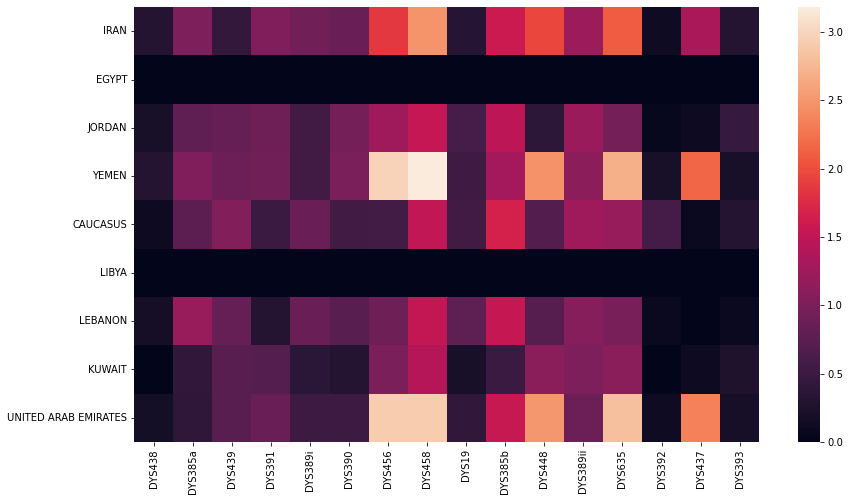

In [32]:
plt.rcParams['figure.figsize'] = [14, 8]
sns.heatmap(entropyDF)

## STRAF - Genetic Diversity
Tables are formatted for STRAF http://cmpg.unibe.ch/shiny/STRAF/.
STRAF provides a whole range of analyses, including Genetic Distance (GD), allele count, $F_{ST}$ based on the uploaded input, which can be microsatellite counts.

In [320]:
## dump table in STRAF compatible format
j1sel.index.name='ind'
j1sel.fillna(0).to_csv('../HaplogroupAnalysis/YHaplo/straf_top10_J1.txt',sep='\t')

In [321]:
import glob
popgens = glob.glob('../HaplogroupAnalysis/YHaplo/STRAF/popgen_statistics_*.tsv')


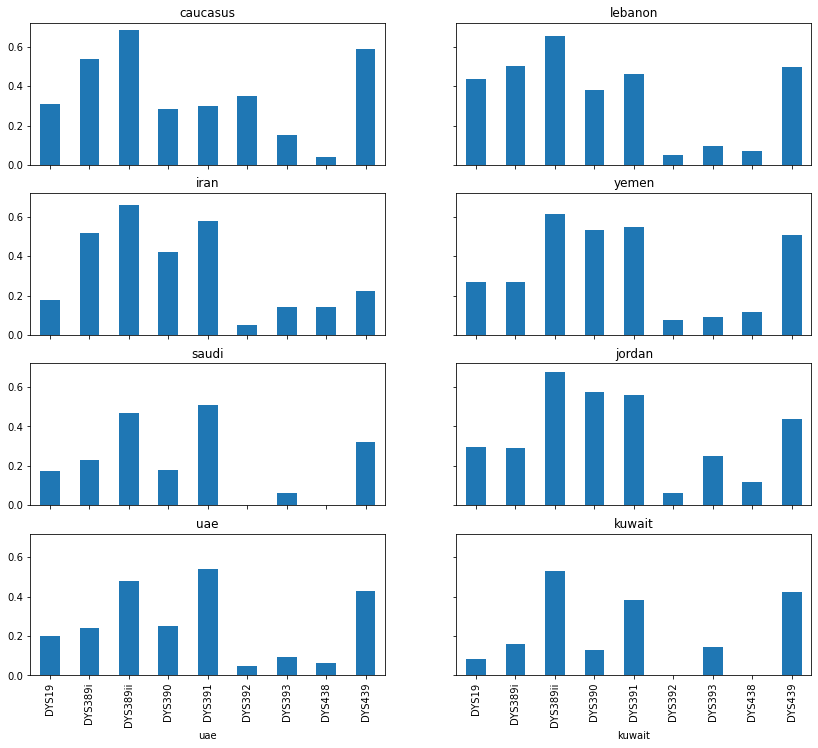

In [322]:
def shortname(popgen): return popgen.split('/')[-1].split('_')[-1][:-4]
plt.rcParams['figure.figsize'] = [14, 12]

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True)
for i, popgen in enumerate(popgens):
    straf = pd.read_csv(popgen, sep='\t')
    straf = straf.set_index('locus')
    pop = shortname(popgen)
    straf.index.name = pop
    straf[['GD']].plot(kind='bar', ax=axes[i//2, i%2], legend=False, title=pop)

### Allele Counts - barstack diagram

In [323]:
def loadCSV(popgen):
    straf = pd.read_csv(popgen, sep='\t')
    straf = straf.set_index('locus')
    return straf.Nall
popgens0 = [shortname(p) for p in popgens]
alleleCount = pd.DataFrame([loadCSV(popgen) for popgen in popgens], index=popgens0)
alleleCount


locus,DYS19,DYS389i,DYS389ii,DYS390,DYS391,DYS392,DYS393,DYS438,DYS439
caucasus,4,4,6,4,3,5,4,3,6
lebanon,5,4,6,4,3,3,3,3,5
iran,2,4,5,5,5,2,3,3,3
yemen,3,4,5,5,5,4,3,5,5
saudi,2,3,4,5,3,1,3,1,3
jordan,4,3,4,5,3,4,3,5,4
uae,4,5,4,5,4,2,2,3,4
kuwait,3,3,6,3,3,1,2,1,4


<AxesSubplot:>

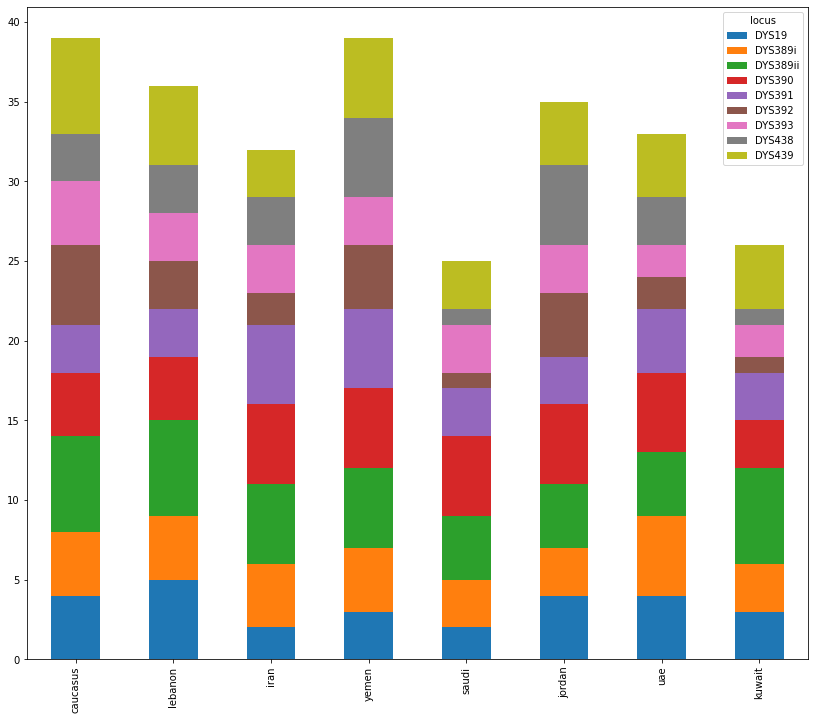

In [324]:
alleleCount.plot(kind='bar', stacked=True)

### Number of Alleles

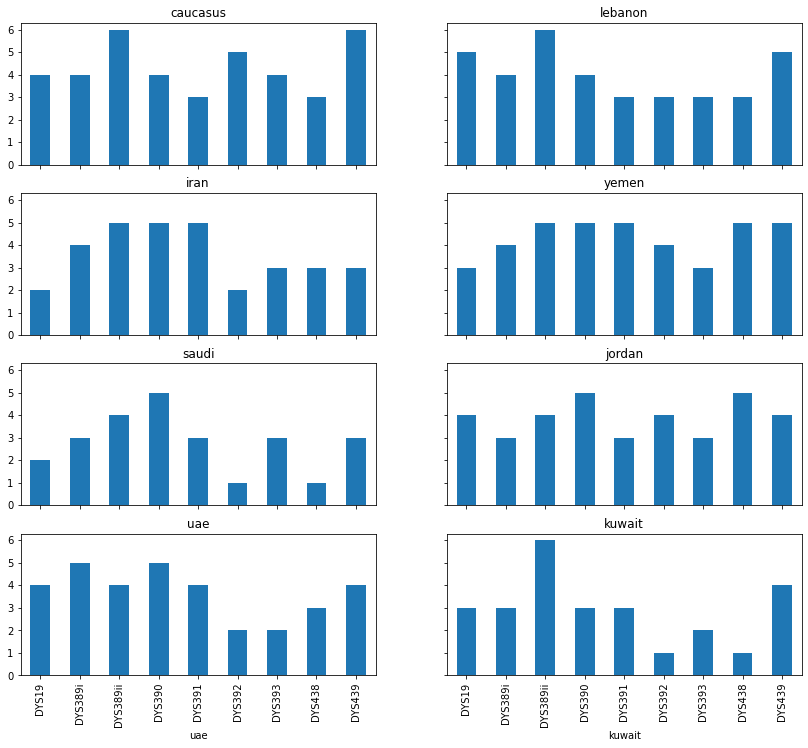

In [325]:
plt.rcParams['figure.figsize'] = [14, 12]

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True)
for i, popgen in enumerate(popgens):
    straf = pd.read_csv(popgen, sep='\t')
    straf = straf.set_index('locus')
    pop = popgen.split('/')[-1].split('_')[-1][:-4]
    straf.index.name = pop
    straf[['Nall']].plot(kind='bar', ax=axes[i//2, i%2], legend=False, title=pop)

### Pairwise population structure $F_{ST}$ 
Deploying STRAF again.

In [326]:
fst = pd.read_csv('../HaplogroupAnalysis/YHaplo/pairwise_fst.tsv', sep='\t')
fst = fst.fillna(0)
fst = fst + fst.T
fst

,AFGHANISTAN,CAUCASUS,CYPRUS,IRAN,JORDAN,KUWAIT,LEBANON,MOROCCO,OMAN,SAUDI ARABIA,UNITED ARAB EMIRATES,YEMEN
AFGHANISTAN,0.000000,0.005200,0.151786,0.042035,0.017434,0.024689,0.011493,0.096930,0.095098,0.042620,0.019650,0.009248
CAUCASUS,0.005200,0.000000,0.009054,0.021402,0.053362,0.129040,0.022754,0.020184,0.014334,0.058722,0.061350,0.048796
CYPRUS,0.151786,0.009054,0.000000,0.053378,0.065150,0.141158,0.023951,0.180374,0.093385,0.138874,0.067667,0.030875
IRAN,0.042035,0.021402,0.053378,0.000000,0.030502,0.109709,0.013576,0.073502,0.019151,0.041980,0.021036,0.013732
JORDAN,0.017434,0.053362,0.065150,0.030502,0.000000,0.113754,0.038123,0.039411,0.033343,0.052168,0.045796,0.015274
KUWAIT,0.024689,0.129040,0.141158,0.109709,0.113754,0.000000,0.127880,0.079411,0.104611,0.104194,0.112189,0.101736
LEBANON,0.011493,0.022754,0.023951,0.013576,0.038123,0.127880,0.000000,0.027098,0.009499,0.041686,0.028657,0.015884
MOROCCO,0.096930,0.020184,0.180374,0.073502,0.039411,0.079411,0.027098,0.000000,0.111844,0.080763,0.044857,0.023214
OMAN,0.095098,0.014334,0.093385,0.019151,0.033343,0.104611,0.009499,0.111844,0.000000,0.052477,0.016266,0.007580
SAUDI ARABIA,0.042620,0.058722,0.138874,0.041980,0.052168,0.104194,0.041686,0.080763,0.052477,0.000000,0.007907,0.026557


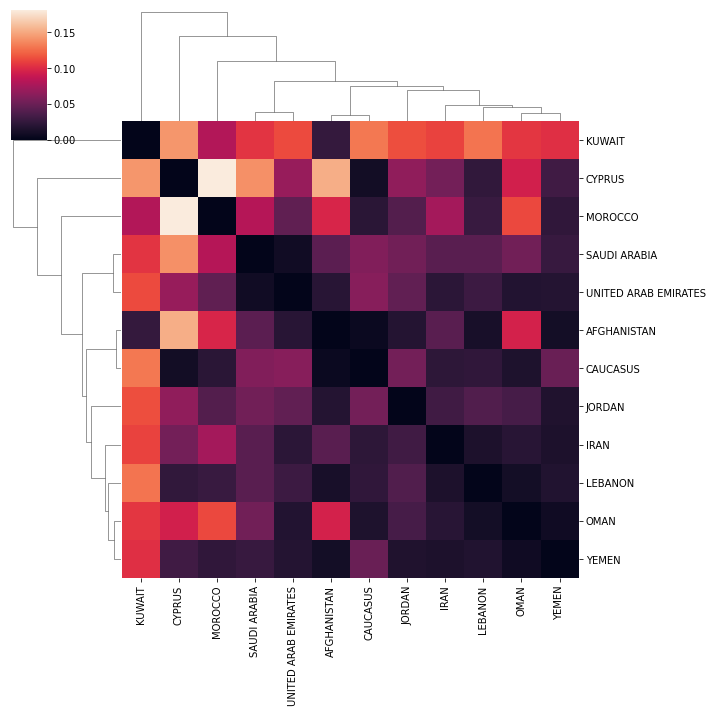

In [327]:
linkage = hc.linkage(sp.distance.squareform(fst), method='average')
sns.clustermap(fst, row_linkage=linkage, col_linkage=linkage)

## Inter-population distances
Goldstein, Cavalli-Sforza PNAS 1995, 

$(\delta\mu)^2 = (\mu_A - \mu_B)^2$

See also 8.2.4.5 Genetic distance, Arlequin manual. Note that it's probably better not to downsample for this measure, as it is population size independent, see PNAS paper.

Note: Kuwait, fx, has many samples around 17 for DYS389ii, and many around 29, same locus.

### Creating distance matrix
calculating $(\delta\mu)^2$ for all population against all.

In [518]:
Counter(j1sel['pop'])

Counter({'YEMEN': 210,
         'UNITED ARAB EMIRATES': 121,
         'KUWAIT': 115,
         'JORDAN': 95,
         'IRAN': 41,
         'LEBANON': 55,
         'CAUCASUS': 346})

In [519]:
pops=set(j1sel['pop'])
D = pd.DataFrame(np.zeros((len(pops),len(pops))), columns=pops, index=pops)

In [520]:
import pdb
def sq(v): return sum([el*el for el in v])

for pop1 in pops:
    for pop2 in pops:
        t1 = j1sel[j1sel['pop']==pop1].iloc[:,1:]
        t2 = j1sel[j1sel['pop']==pop2].iloc[:,1:]
        muA = np.array(t1.mean(axis=0)) 
        muB = np.array(t2.mean(axis=0))
        try:
            D.loc[pop1, pop2] = sq(muA-muB)
        except ValueError:
            pdb.set_trace()
#        if pop1.startswith('YEMEN') and pop2.startswith('TURKEY'):
#            pdb.set_trace()
D

,CAUCASUS,IRAN,YEMEN,UNITED ARAB EMIRATES,KUWAIT,LEBANON,JORDAN
CAUCASUS,0.000000,6.058559,6.308291,6.263845,505.033635,2.832019,6.548432
IRAN,6.058559,0.000000,1.193233,0.666448,555.214896,2.153044,1.597760
YEMEN,6.308291,1.193233,0.000000,0.558859,526.502788,1.484461,0.550985
UNITED ARAB EMIRATES,6.263845,0.666448,0.558859,0.000000,552.093377,2.247379,0.860875
KUWAIT,505.033635,555.214896,526.502788,552.093377,0.000000,508.047092,524.843687
LEBANON,2.832019,2.153044,1.484461,2.247379,508.047092,0.000000,2.572822
JORDAN,6.548432,1.597760,0.550985,0.860875,524.843687,2.572822,0.000000


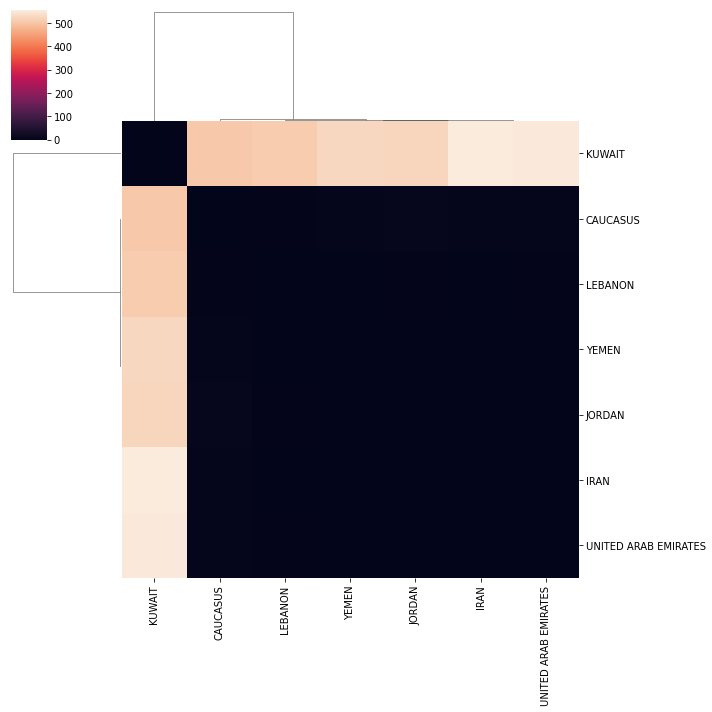

In [522]:
linkage = hc.linkage(sp.distance.squareform(D), method='average')
sns.clustermap(D, row_linkage=linkage, col_linkage=linkage)


In [523]:
D

,CAUCASUS,IRAN,YEMEN,UNITED ARAB EMIRATES,KUWAIT,LEBANON,JORDAN
CAUCASUS,0.000000,6.058559,6.308291,6.263845,505.033635,2.832019,6.548432
IRAN,6.058559,0.000000,1.193233,0.666448,555.214896,2.153044,1.597760
YEMEN,6.308291,1.193233,0.000000,0.558859,526.502788,1.484461,0.550985
UNITED ARAB EMIRATES,6.263845,0.666448,0.558859,0.000000,552.093377,2.247379,0.860875
KUWAIT,505.033635,555.214896,526.502788,552.093377,0.000000,508.047092,524.843687
LEBANON,2.832019,2.153044,1.484461,2.247379,508.047092,0.000000,2.572822
JORDAN,6.548432,1.597760,0.550985,0.860875,524.843687,2.572822,0.000000


In [524]:
exclude='turkey kuwait palestine jordan syria afghanistan'.upper().split()
exclude='turkey kuwait afghanistan'.upper().split()

keepCols = list(set(D.columns.values).difference(exclude))
D = D[keepCols].loc[keepCols]

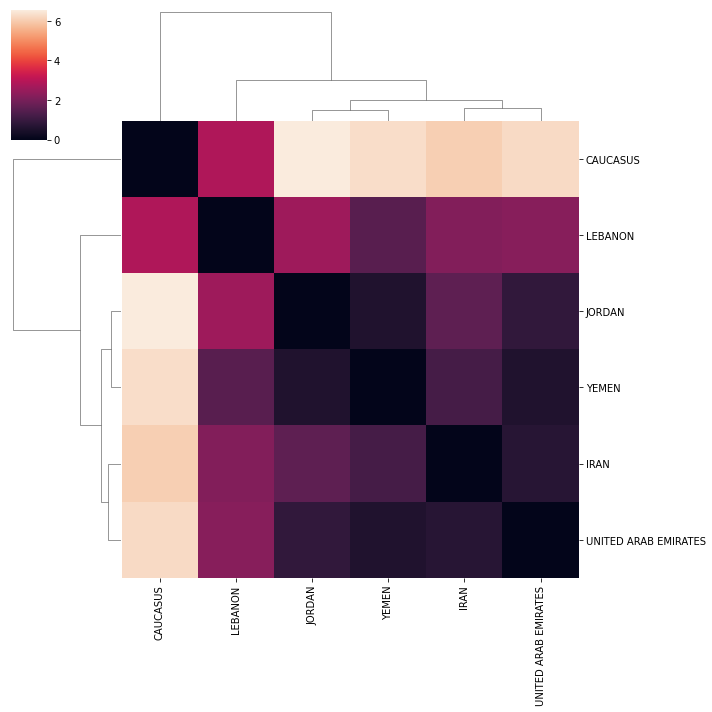

In [525]:
linkage = hc.linkage(sp.distance.squareform(D), method='average')
sns.clustermap(D, row_linkage=linkage, col_linkage=linkage)